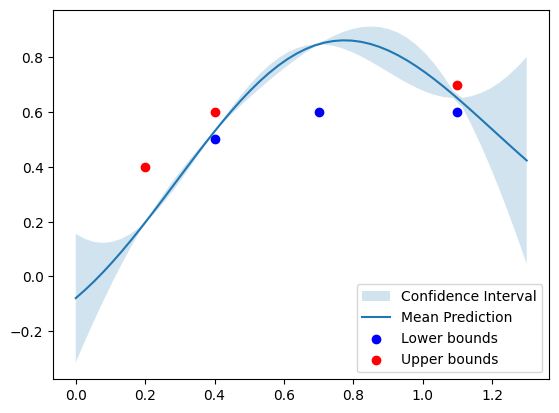

In [16]:
import numpy as np
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import expit  # Sigmoid function

# Define the RBF Kernel
def rbf_kernel(X1, X2, length_scale=1.0, variance=1.0):
    dist = cdist(X1, X2, 'sqeuclidean')
    return variance * np.exp(-0.5 * dist / length_scale**2)

# Define the Negative Log Marginal Likelihood
def nll(f, K, y_lower, y_upper, alpha):
    K_inv = np.linalg.inv(K + 1e-6 * np.eye(K.shape[0]))  # Add small noise for numerical stability
    nll_prior = 0.5 * f.T @ K_inv @ f + 0.5 * np.linalg.slogdet(K)[1]
    sigmoid_lower = expit(alpha * (f - y_lower))
    sigmoid_upper = expit(alpha * (y_upper - f))
    nll_likelihood = -np.sum(np.log(sigmoid_lower) + np.log(sigmoid_upper))
    return nll_prior + nll_likelihood

# Define the prediction function
def gp_predict(X_train, f_opt, X_test, kernel_func, length_scale, variance):
    K_train = kernel_func(X_train, X_train, length_scale, variance)
    K_test = kernel_func(X_test, X_train, length_scale, variance)
    K_test_test = kernel_func(X_test, X_test, length_scale, variance)
    K_inv = np.linalg.inv(K_train + 1e-6 * np.eye(K_train.shape[0]))
    
    # Predictive mean and variance
    mean = K_test @ K_inv @ f_opt
    cov = K_test_test - K_test @ K_inv @ K_test.T
    return mean, cov

# Main code
# Training data
X_train = np.array([[0.2], [0.4], [0.7], [1.1]])  # Input points
y_lower = np.array([-np.inf, 0.5, 0.6, 0.6])  # Lower bounds of intervals
y_upper = np.array([0.4, 0.6, np.inf, 0.7])  # Upper bounds of intervals

# Hyperparameters
length_scale = 0.5
variance = 1.0
alpha = 10.0  # Steepness of the sigmoid

# Kernel matrix
K = rbf_kernel(X_train, X_train, length_scale, variance)

# Initialize latent function values
f_init = np.zeros(X_train.shape[0])

# Optimize latent function values
res = minimize(
    nll,
    f_init,
    args=(K, y_lower, y_upper, alpha),
    method="L-BFGS-B",
    options={"disp": True}
)
f_opt = res.x

# Test data
X_test = np.linspace(0, 1.3, 50).reshape(-1, 1)
mean, cov = gp_predict(X_train, f_opt, X_test, rbf_kernel, length_scale, variance)

# Results
import matplotlib.pyplot as plt

std_dev = np.sqrt(np.diag(cov))
plt.fill_between(X_test.ravel(), mean - 2 * std_dev, mean + 2 * std_dev, alpha=0.2, label="Confidence Interval")
plt.plot(X_test, mean, label="Mean Prediction")
plt.scatter(X_train, y_lower, color="blue", label="Lower bounds")
plt.scatter(X_train, y_upper, color="red", label="Upper bounds")
plt.legend()
plt.show()